In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath("..")) # add parent directory for import

import warnings
warnings.filterwarnings('ignore') # suppress itcsimlib warnings about rescaling, etc.

## Chapter 1: The Basics

Welcome to the itcsimlib tutorial. This tutorial will guide you through a series of tasks that cover the essential itcsimlib "experience": simulating experiments, evaluating different models, fitting a model to experimental data, etc.

Note that itcsimlib doesn't possess a GUI. You will need to write scripts in Python or Jupyter notebooks (like this one!) that make use of itcsimlib classes and functions. Users of XPLOR-NIH and other programmatic analysis tools will find this quite familiar. If you're not completely comfortable with Python, don't worry! These tutorial files themselves can be used as good starting points for your own experiments, as well as the scripts in the "examples" directory.

It's up to you whether you want to use Jupyter notebooks or write your own straight ".py" script files. There's a slight performance penalty when using Jupyter notebooks, but the built-in documentation capabilities afforded by Jupyter is usually worth it. It's usually good idea to explain your reasoning at each step both for the benefit of yourself later on and for those attempting to understand your work.

Before we start, import all of the core itcsimlib classes:

In [2]:
from itcsimlib import *

We create the essential ITC simulator by instantiating an ITCSim object with a few required arguments:

In [3]:
sim = ITCSim(T0=298.15, units="kcal", verbose=True)

The meaning of the arguments necessary to create the simulator should be relatively intuitive.

Because many thermodynamic parameters vary with temperature, you'll need to specify a reference temperature (the `T0` argument), which becomes especially important when you're working with data acquired at multiple experimental temperatures.

The `units` argument is also intuitive, and can be `J` or `kJ` for Joules or kilojoules, `cal`, or `kcal` for calories and kilocalories respectively.

Lastly, the `verbose` argument tells the simulator whether or not to print extra information when you run the script. You probably want that info, so here the argument is set to True

Next, let's add a theoretical (i.e. "synthetic") ITC experiment to the simulator:

In [4]:
experiment = sim.add_experiment_synthetic(
    T=298.15,
    V0=1416.6,
    injections=[5.0]*50,
    Cell={"Macromolecule":1E-6},
    Syringe={"Ligand":30E-6},
    noise=1.0,
    title='Test_Experiment_1'
)

This theoretical experiment takes place at 25C (298.15K), has a starting cell volume of 1416.6 uL, and is comprised of fifty 5 uL injections.

The cell contains our binding macromolecule at a starting concentration of 1 uMol concentration, while our syringe contains our ligand at 30 uMol. Here, we've chosen to add 1 kcal/mol simulated noise. We've also given the experiment the catchy name `Test_Experiment_1`.

However, to model a binding process, you'll need specify a model. Let's use an independent two-mode description of binding. We'll need to import it and then instantiate it with the number of independent modes we want to model.

In [5]:
from itcsimlib.model_independent import NModes

sim.set_model( NModes(modes=2) )

To see the details of the model, we can just print the model to our console, which is very useful as it will tell us the names of the binding components and information about all the model's fitting parameters:

In [6]:
print(sim.model)


Model: itcsimlib.model_independent.NModes

Description:
A 4n-parameter phenomological model describing binding to n independent types of sites.

Components:
Index	Name	Description
1)	Macromolecule	
2)	Ligand	

Parameters:
Index	Param     Type                Value               Description
1)	n1        Stoichiometry       1.000 sites         Binding site stoichiometry
2)	dG1       Free energy         0.000 kcal/mol      Free energy change upon binding
3)	dH1       Enthalpy            0.000 kcal/mol      Enthalpy change upon binding
4)	dCp1      Heat capacity       0.000 kcal/mol/K    Heat capacity change
5)	n2        Stoichiometry       1.000 sites         Binding site stoichiometry
6)	dG2       Free energy         0.000 kcal/mol      Free energy change upon binding
7)	dH2       Enthalpy            0.000 kcal/mol      Enthalpy change upon binding
8)	dCp2      Heat capacity       0.000 kcal/mol/K    Heat capacity change



You'll notice that all of the thermodynamic parameters are set to zero. Let's change some of these to more reasonable values.

In [7]:
sim.set_model_params(n1=1, n2=3, dG1=-11, dG2=-10, dH1=-15, dH2=+10)

Remember that back when we created the simulator we specified our values would be in kcal.

With these arguments, we've said that one binding mode occurs with a stoichiometry of 1:1 ligand to macromolecule, and with a free energy change of -11 kcal/mol, and an exothermic change in enthalpy of -15 kcal/mol

The second binding mode occurs with a stoichiometry of 3 ligands per molecule, a slightly weaker -10 kcal/mol free energy change, and an endothermic change in enthalpy of +10 kcal/mol.

Now that we've updated the model parameters, let's verify that they've been set.

In [8]:
print(sim.model)


Model: itcsimlib.model_independent.NModes

Description:
A 4n-parameter phenomological model describing binding to n independent types of sites.

Components:
Index	Name	Description
1)	Macromolecule	
2)	Ligand	

Parameters:
Index	Param     Type                Value               Description
1)	n1        Stoichiometry       1.000 sites         Binding site stoichiometry
2)	dG1       Free energy         -11.000 kcal/mol    Free energy change upon binding
3)	dH1       Enthalpy            -15.000 kcal/mol    Enthalpy change upon binding
4)	dCp1      Heat capacity       0.000 kcal/mol/K    Heat capacity change
5)	n2        Stoichiometry       3.000 sites         Binding site stoichiometry
6)	dG2       Free energy         -10.000 kcal/mol    Free energy change upon binding
7)	dH2       Enthalpy            10.000 kcal/mol     Enthalpy change upon binding
8)	dCp2      Heat capacity       0.000 kcal/mol/K    Heat capacity change



Just setting the parameters doesn't really do anything. Now we need to run the simulator, which will populate our synthetic experiment:

In [9]:
sim.run() # populates the experimental data component of Test_Experiment_1
sim.run() # populates the fit data component

1.11632840875569

After a successful simulation, the reduced chi-square ($\chi_{red}^{2}$) value between the experimental data and the fit will be returned.

In this example with a synthetic/theoretical experiment, the first time we execute a model we are actually generating the "experimental" data for the experiment, and each subsequent model execution will attempt to fit that initial dataset. Thus, because we aren't changing the model parameters, the reduced chi-square between the two simulations should be close to unity, and it is.

After execution, all of the experiments that we've assigned to the simulator will now contain theoretical binding data (in this case, we have just the one experiment). Let's take a look at the simulated curves:

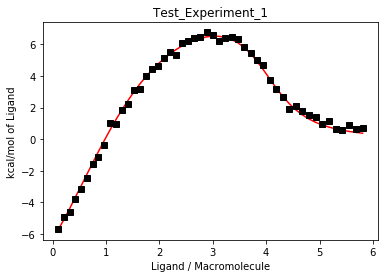

In [10]:
sim.make_plots()

Note that if we'd provided a `hardcopy=True` argument to `make_plots()`, itcsimlib will save plots to a file instead of just displaying them in a plot window.

When we're all done, we need to tell the simulator so it can stop any processing threads and clean up:

In [11]:
sim.done()

Congratulations. You've reached the end of Chapter 1. In the next chapter we'll cover fitting real experimental data with a model.